# Final Project Machine Learning

## Juan David Sanchez & Alejandro Gil

### Enfasís en Análitica Aplicada


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pathlib import Path
from typing import Callable
from functools import wraps
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from prefect import flow, task, get_run_logger
from sklearn import metrics 
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score


In [2]:
def timing_decorator(func: Callable) -> Callable:
    '''Custom decorator to time task execution'''
    @wraps(func)
    def wrapper(*args, **kwargs):
        logger = get_run_logger()
        start_time = time.time()

        # Execute the original function
        result = func(*args, **kwargs)

        end_time = time.time()
        execution_time = end_time - start_time

        logger.info(f"Task '{func.__name__}' completed in {execution_time:.2f} seconds")
        return result

    return wrapper

In [3]:
@task
@timing_decorator
def load_data() -> pd.DataFrame:
    df = pd.read_csv('dataset_small.csv')
    df.head(5)
    return df

In [4]:
@task
@timing_decorator
def distribution_plotter(df):
    print("Class Distribution:")
    class_dist = df['phishing'].value_counts()
    ax = class_dist.plot(kind='bar')
    plt.title('Class distribution')
    plt.xlabel('Class')
    plt.ylabel('Count')
    for i in ax.containers:
        ax.bar_label(i, label_type='edge', padding=1.5, fontsize=10, color='black')
    plt.show()

    print("\nPercentage Distribution:")
    perc_dist = df['phishing'].value_counts(normalize=True) * 100
    perc_dist.plot(
            kind='pie',
            autopct='%1.1f%%',  
            startangle=90,        
            shadow=True,         
            colormap='tab20'      
        )
    plt.title('Percentage distribution')
    plt.ylabel('Count')  
    plt.show()

In [5]:
@task
@timing_decorator
def descriptor(df):
    print(f"Total missing values: {df.isnull().sum().sum()}")
    print(f"Duplicate: {df.duplicated().sum()}\n")
    print(df.describe().T)


#### Correlation

In [6]:
@task
@timing_decorator
def correlation(df):
    correlation = df.corr()['phishing'].sort_values(ascending=False)

    top_corr = correlation[1:16]
    print(top_corr)

    top_corr.plot(kind='barh')
    plt.title('15 characteristics most correlated with phishing')
    plt.xlabel('Correlation')
    plt.show()

In [7]:
@task
@timing_decorator
def preprocessing(df):
    X = df.drop('phishing', axis=1) 
    y = df['phishing']

    print(f"\nX (Features): {X.shape}")
    print(f"y (Target): {y.shape}")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


    print("Tamaño de X_train: {}\nTamaño de y_train: {}".format(X_train.shape, y_train.shape))
    print("Tamaño de X_test: {}\nTamaño de y_test: {}".format(X_test.shape, y_test.shape))

    return X_train, X_test, y_train, y_test


In [8]:
@task
@timing_decorator
def confusion_matrix(class_names, model, X_test, y_test):
 
    print("Visualización de desempeño con Matriz de Confusión:")
    y_pred = model.predict(X_test)
  
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=None
    )
 
    disp.ax_.set_title("Confusion Matrix")
    print("Confusion Matrix")
    print(disp.confusion_matrix)
 
    plt.show()

In [9]:
@task
@timing_decorator
def show_classificationreport(model, X_test, y_test, class_names=None):
    
    y_pred = model.predict(X_test)

    # classification_report expects target_names to be an iterable of strings or None
    if class_names is not None:
        try:
            # convert each name to string to avoid TypeError when names are ints
            target_names = [str(c) for c in class_names]
        except Exception:
            target_names = None
    else:
        target_names = None

    print("Clasification Report")
    report = classification_report(y_test, y_pred, target_names=target_names)
    print(report)
    
    return report

In [10]:
@task
@timing_decorator
def roc_curve_analysis(model, X_test, y_test):
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    else: 
        y_scores = model.decision_function(X_test)
    
    fpr, tpr, _ = metrics.roc_curve(y_test, y_scores)
    roc_auc = metrics.auc(fpr, tpr)
    print(f"AUC-ROC: {roc_auc:.4f}")
    
    metrics.RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.show()
    
    return roc_auc

In [11]:
@task
@timing_decorator
def multiple_roc(models_dict, X_test, y_test):
    plt.figure()
    for model_name, model in models_dict.items():
        if hasattr(model, "predict_proba"):
            y_scores = model.predict_proba(X_test)[:, 1]
        else: 
            y_scores = model.decision_function(X_test)
        
        fpr, tpr, _ = metrics.roc_curve(y_test, y_scores)
        roc_auc = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')  
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison')
    plt.legend(loc='lower right')
    plt.show()

In [12]:
@task
@timing_decorator
def plot_learning_curve(model, X_train, y_train, model_name):
    """Graficar curva de aprendizaje - versión simple"""
    
    from sklearn.model_selection import learning_curve
    
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train, y_train, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10)
    )
    
    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, 'o-', label='Train', linewidth=2)
    plt.plot(train_sizes, val_mean, 'o-', label='Validation', linewidth=2)
    plt.xlabel('Training Size')
    plt.ylabel('Accuracy')
    plt.title(f'Learning Curve - {model_name}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [13]:
@task
@timing_decorator
def bar_chart(models_dict, X_test, y_test):
    accuracies = {}
    for model_name, model in models_dict.items():
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracies[model_name] = acc

    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.title('Model Accuracy Comparison')
    for i, v in enumerate(accuracies.values()):
        plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontsize=10)
    plt.xticks(rotation=45)
    plt.show()

#### Gradient Boosting

In [14]:
@task
@timing_decorator
def gradient_boosting(X_train, X_test, y_train, y_test):

    print("Gradient Boosting") 
    gb_model = GradientBoostingClassifier(
        n_estimators=100, 
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )

   
    gb_model.fit(X_train, y_train)

    y_pred = gb_model.predict(X_test)

    resultado_comparacion = pd.concat([
        X_test,
        pd.Series(y_test, name='Actual', index=X_test.index),
        pd.Series(y_pred, name='Predicción', index=X_test.index)
    ], axis=1)
    
    print("Comparación de predicciones (primeras 5 filas):")
    print(resultado_comparacion.head())

    cv_scores = cross_val_score(gb_model, X_train, y_train, cv=5)
    print(f"\nResultados de la validación cruzada en gradient boosting:: {cv_scores}")
    print(f"Resultado promedio de la validación cruzada en gradient boosting:: {np.average(cv_scores):.4f}")

    print("Exactitud (accuracy) en prueba (testing) del gradient boosting:", metrics.accuracy_score(y_test, y_pred))

    return gb_model

#### Random Forest

In [15]:
@task
@timing_decorator
def random_forest(X_train, X_test, y_train, y_test):
    
    print("Random Forest") 

    rf_model = RandomForestClassifier(
    n_estimators=100, 
    max_depth=15,              
    min_samples_split=10,      
    min_samples_leaf=4,       
    random_state=42
)
    
    # Train the model
    rf_model.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_model.predict(X_test)

    
    cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5)
    print(f"\nResultados de la validación cruzada en Random Forest: {cv_scores}")
    print(f"Resultado promedio de la validación cruzada en Random Forest: {np.average(cv_scores):.4f}")
    print("Exactitud (accuracy) en prueba (testing) del Random Forest:", metrics.accuracy_score(y_test, y_pred))
    
    return rf_model

#### Knn

In [16]:
@task
@timing_decorator
def knn(X_train, X_test, y_train, y_test):
    
    print("Knn") 
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    resultado_comparacion = pd.concat([
        X_test,
        pd.Series(y_test, name='Actual', index=X_test.index),
        pd.Series(y_pred, name='Predicción', index=X_test.index)
    ], axis=1)

    print("Comparación de hiperparámetros:")
    for k in [1, 3, 5, 7]:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        acc = knn.score(X_test, y_test)
        print(f"KNN (n_neighbors={k}) - Prueba de accuracy: {acc:.4f}")
    
    print("Comparación de predicciones (primeras 5 filas):")
    print(resultado_comparacion.head())
    
    print("Score sobre el conjunto de test: {:.3f}".format(knn.score(X_test, y_test)))
 
    np.set_printoptions(precision=2)
    #Validación cruzada datos entrenamiento 
    cv_scores = cross_val_score(knn, X_train, y_train, cv=5)
    print(cv_scores)
 
    print("Desempeño promedio del kNN:")
    print(np.average(cv_scores))
 
    print("Exactitud (accuracy) en prueba (testing) del kNN:", metrics.accuracy_score(y_test, y_pred))
    
    return knn 

In [17]:
@task
@timing_decorator
def knn_scaler(X_train, X_test, y_train, y_test):
    
    print("Knn Scaler") 
    scaler = StandardScaler()
    x_train_scaler = scaler.fit_transform(X_train)
    x_test_scaler = scaler.transform(X_test)
    
    knn_scaled = KNeighborsClassifier(n_neighbors=5)
    knn_scaled.fit(x_train_scaler, y_train)
    y_pred = knn_scaled.predict(x_test_scaler)
    
    comparacion_df = pd.concat([
        X_test,
        pd.Series(y_test, name='Actual', index=X_test.index),
        pd.Series(y_pred, name='Predicción', index=X_test.index)
    ], axis=1)
    
    for k in [1, 3, 5, 7]:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(x_train_scaler, y_train)
        acc = knn.score(x_test_scaler, y_test)
        print(f"KNN Scaler(n_neighbors={k}) - Prueba de accuracy: {acc:.4f}")
    
    print("Comparación de predicciones:")
    print(comparacion_df.head())
 
    print("Score sobre el conjunto de test: {:.3f}".format(knn_scaled.score(x_test_scaler, y_test)))
 
    np.set_printoptions(precision=2)
    cv_scores = cross_val_score(knn_scaled, x_train_scaler, y_train, cv=5)
    print(cv_scores)
 
    print("Desempeño promedio:")
    print(np.average(cv_scores))
 
    print("Exactitud (accuracy) en prueba (testing):", metrics.accuracy_score(y_test, y_pred))
 
    
    return knn_scaled, x_test_scaler

#### SVM


In [18]:
@task
@timing_decorator
def svm(X_train, X_test, y_train, y_test):
    
    print("SVM") 
    svm_class = SVC(kernel='rbf', random_state=42)
    svm_class.fit(X_train, y_train)

    y_pred = svm_class.predict(X_test)

    resultado_comparacion = pd.concat([
        X_test,
        pd.Series(y_test, name='Actual', index=X_test.index),
        pd.Series(y_pred, name='Predicción', index=X_test.index)
    ], axis=1)

    print("Comparación de predicciones (primeras 5 filas):")
    print(resultado_comparacion.head())
   
    print("Score de entrenamiento: {:.3f}".format(svm_class.score(X_train, y_train)))
    print("Score de test: {:.3f}".format(svm_class.score(X_test, y_test)))
 
    np.set_printoptions(precision=2)
    cv_scores = cross_val_score(svm_class, X_train, y_train, cv=3)
    print("Scores de validación cruzada:")
    print(cv_scores)
 
    print("Desempeño promedio:")
    print(np.average(cv_scores))
 
    print("Accuracy en el testing:", metrics.accuracy_score(y_test, y_pred))
    
    return svm_class

In [19]:
@task
@timing_decorator
def svm_scaler(X_train, X_test, y_train, y_test):
    
    print("SVM Scaler") 
    scaler = StandardScaler()
    x_train_scaler = scaler.fit_transform(X_train)
    x_test_scaler = scaler.transform(X_test)
    
    svm_class_scaled = SVC(kernel='rbf', random_state=0)
    svm_class_scaled.fit(x_train_scaler, y_train)

    y_pred = svm_class_scaled.predict(x_test_scaler)
    
    resultado_comparacion = pd.concat([
        X_test,
        pd.Series(y_test, name='Actual', index=X_test.index),
        pd.Series(y_pred, name='Predicción', index=X_test.index)
    ], axis=1)
    
    print("Comparación de predicciones (primeras 5 filas):")
    print(resultado_comparacion.head())
   
    print("Score de entrenamiento: {:.3f}".format(svm_class_scaled.score(x_train_scaler, y_train)))
    print("Score de test: {:.3f}".format(svm_class_scaled.score(x_test_scaler, y_test)))
 
    np.set_printoptions(precision=2)
    cv_scores = cross_val_score(svm_class_scaled, x_train_scaler, y_train, cv=3)
    print("Scores de validación cruzada:")
    print(cv_scores)
 
    print("Desempeño promedio:")
    print(np.average(cv_scores))
 
    print("Accuracy en el testing:", metrics.accuracy_score(y_test, y_pred))
 
    
    return svm_class_scaled, x_test_scaler

In [20]:
@task
@timing_decorator
def svm_linearsvc(X_train, X_test, y_train, y_test):
    
    print("SVM con LinearSVC") 

    linear_svm = LinearSVC(random_state=42, max_iter=10000, dual='auto')
    linear_svm.fit(X_train, y_train)

    y_pred = linear_svm.predict(X_test)

    resultado_comparacion = pd.concat([
        X_test,
        pd.Series(y_test, name='Actual', index=X_test.index),
        pd.Series(y_pred, name='Predicción', index=X_test.index)
    ], axis=1)

    print("Comparación de predicciones (primeras 5 filas):")
    print(resultado_comparacion.head())
   
    print("Score de entrenamiento: {:.3f}".format(linear_svm.score(X_train, y_train)))
    print("Score de test: {:.3f}".format(linear_svm.score(X_test, y_test)))

    np.set_printoptions(precision=2)
    cv_scores = cross_val_score(linear_svm, X_train, y_train, cv=3)
    print("Scores de validación cruzada:")
    print(cv_scores)
 
    print("Desempeño promedio:")
    print(np.average(cv_scores))
 
    print("Accuracy en el testing:", metrics.accuracy_score(y_test, y_pred))
    
    return linear_svm

In [21]:
@task
@timing_decorator
def svm_scalerlinear(X_train, X_test, y_train, y_test):
    
    print("SVM Scaler con LinearSVC") 
    scaler = StandardScaler()
    x_train_scaler = scaler.fit_transform(X_train)
    x_test_scaler = scaler.transform(X_test)
    
    linear_svmscaled = LinearSVC(random_state=42, max_iter=10000, dual='auto', tol=1e-4)
    linear_svmscaled.fit(x_train_scaler, y_train)

    y_pred = linear_svmscaled.predict(x_test_scaler)
    
    resultado_comparacion = pd.concat([
        X_test,
        pd.Series(y_test, name='Actual', index=X_test.index),
        pd.Series(y_pred, name='Predicción', index=X_test.index)
    ], axis=1)
    
    print("Comparación de predicciones (primeras 5 filas):")
    print(resultado_comparacion.head())
   
    print("Score de entrenamiento: {:.3f}".format(linear_svmscaled.score(x_train_scaler, y_train)))
    print("Score de test: {:.3f}".format(linear_svmscaled.score(x_test_scaler, y_test)))

    np.set_printoptions(precision=2)
    cv_scores = cross_val_score(linear_svmscaled, x_train_scaler, y_train, cv=3)
    print("Scores de validación cruzada:")
    print(cv_scores)
 
    print("Desempeño promedio:")
    print(np.average(cv_scores))
 
    print("Accuracy en el testing:", metrics.accuracy_score(y_test, y_pred))


    return linear_svmscaled, x_test_scaler

20:55:36.113 | INFO    | prefect - Starting temporary server on http://127.0.0.1:8856
See https://docs.prefect.io/v3/concepts/server#how-to-guides for more information on running a dedicated Prefect server.

20:55:41.027 | INFO    | Flow run 'wild-goose' - Beginning flow run 'wild-goose' for flow 'small-dataset-flow'

20:55:41.356 | INFO    | Task run 'load_data-735' - Task 'load_data' completed in 0.28 seconds

20:55:41.356 | INFO    | Task run 'load_data-735' - Finished in state Completed()

Class Distribution:


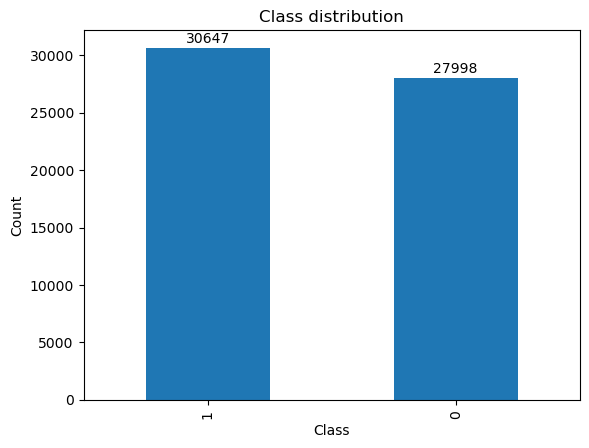


Percentage Distribution:


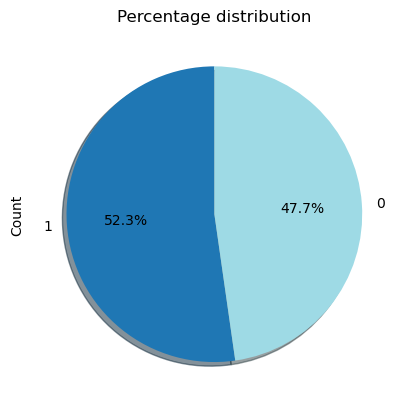

20:55:41.783 | INFO    | Task run 'distribution_plotter-3b6' - Task 'distribution_plotter' completed in 0.21 seconds

20:55:41.792 | INFO    | Task run 'distribution_plotter-3b6' - Finished in state Completed()

Total missing values: 0
Duplicate: 1240

                        count      mean       std  min  25%  50%  75%   max
qty_dot_url           58645.0  2.284338  1.473209  1.0  2.0  2.0  3.0  24.0
qty_hyphen_url        58645.0  0.457123  1.339340  0.0  0.0  0.0  0.0  35.0
qty_underline_url     58645.0  0.171285  0.801919  0.0  0.0  0.0  0.0  21.0
qty_slash_url         58645.0  1.937522  2.037525  0.0  0.0  1.0  3.0  44.0
qty_questionmark_url  58645.0  0.014102  0.138156  0.0  0.0  0.0  0.0   9.0
...                       ...       ...       ...  ...  ...  ...  ...   ...
qty_redirects         58645.0  0.303419  0.815315 -1.0  0.0  0.0  1.0  17.0
url_google_index      58645.0  0.001279  0.037599 -1.0  0.0  0.0  0.0   1.0
domain_google_index   58645.0  0.002234  0.047927 -1.0  0.0  0.0  0.0   1.0
url_shortened         58645.0  0.008287  0.090657  0.0  0.0  0.0  0.0   1.0
phishing              58645.0  0.522585  0.499494  0.0  0.0  1.0  1.0   1.0

[112 rows x 8 columns]


20:55:42.252 | INFO    | Task run 'descriptor-27c' - Task 'descriptor' completed in 0.29 seconds

20:55:42.258 | INFO    | Task run 'descriptor-27c' - Finished in state Completed()

qty_slash_directory           0.644812
qty_dollar_file               0.626792
qty_hashtag_file              0.626792
qty_slash_file                0.626792
qty_hashtag_directory         0.626792
qty_questionmark_directory    0.626792
qty_questionmark_file         0.626792
qty_at_file                   0.626609
qty_exclamation_file          0.625984
qty_and_file                  0.625704
qty_tilde_file                0.625303
qty_equal_file                0.623972
qty_space_file                0.622477
qty_comma_file                0.621802
qty_exclamation_directory     0.621736
Name: phishing, dtype: float64


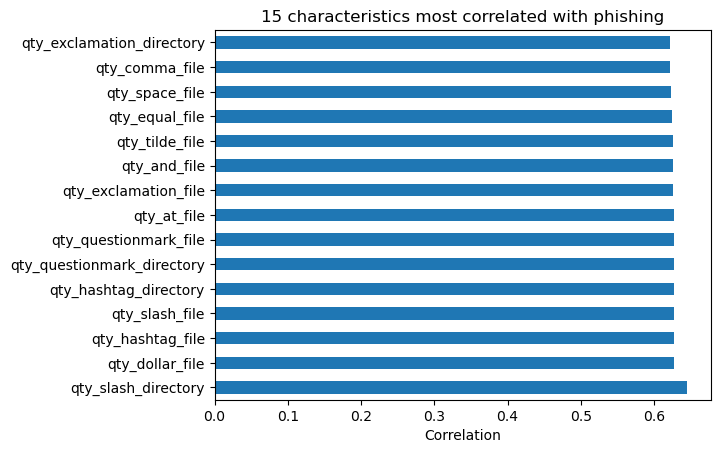

20:55:43.776 | INFO    | Task run 'correlation-802' - Task 'correlation' completed in 1.35 seconds

20:55:43.781 | INFO    | Task run 'correlation-802' - Finished in state Completed()


X (Features): (58645, 111)
y (Target): (58645,)
Tamaño de X_train: (46916, 111)
Tamaño de y_train: (46916,)
Tamaño de X_test: (11729, 111)
Tamaño de y_test: (11729,)


20:55:44.017 | INFO    | Task run 'preprocessing-589' - Task 'preprocessing' completed in 0.07 seconds

20:55:44.022 | INFO    | Task run 'preprocessing-589' - Finished in state Completed()

Gradient Boosting
Comparación de predicciones (primeras 5 filas):
       qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  \
8833             2               0                  2              2   
54083            2               0                  0              1   
54281            2               0                  0              1   
47386            4               0                  0              0   
37042            2               0                  0              0   

       qty_questionmark_url  qty_equal_url  qty_at_url  qty_and_url  \
8833                      0              0           0            0   
54083                     0              0           0            0   
54281                     0              0           0            0   
47386                     0              0           0            0   
37042                     0              0           0            0   

       qty_exclamation_url  qty_space_url  ...  qty_nameservers  \
8833   

20:56:58.198 | INFO    | Task run 'gradient_boosting-4d9' - Task 'gradient_boosting' completed in 73.78 seconds

20:56:58.202 | INFO    | Task run 'gradient_boosting-4d9' - Finished in state Completed()

Visualización de desempeño con Matriz de Confusión:
Confusion Matrix
[[5177  423]
 [ 384 5745]]


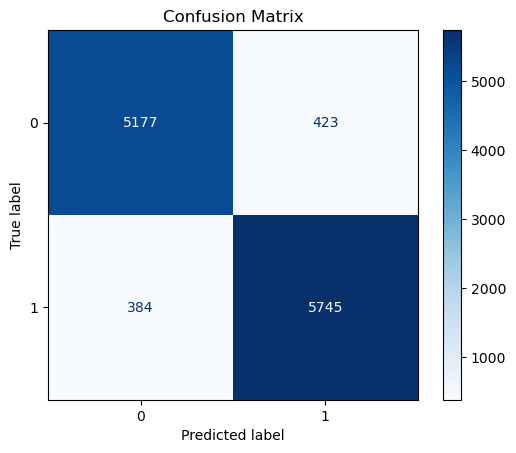

20:56:58.405 | INFO    | Task run 'confusion_matrix-b6c' - Task 'confusion_matrix' completed in 0.11 seconds

20:56:58.411 | INFO    | Task run 'confusion_matrix-b6c' - Finished in state Completed()

Clasification Report
              precision    recall  f1-score   support

           0       0.93      0.92      0.93      5600
           1       0.93      0.94      0.93      6129

    accuracy                           0.93     11729
   macro avg       0.93      0.93      0.93     11729
weighted avg       0.93      0.93      0.93     11729



20:56:58.528 | INFO    | Task run 'show_classificationreport-c44' - Task 'show_classificationreport' completed in 0.03 seconds

20:56:58.531 | INFO    | Task run 'show_classificationreport-c44' - Finished in state Completed()

AUC-ROC: 0.9800


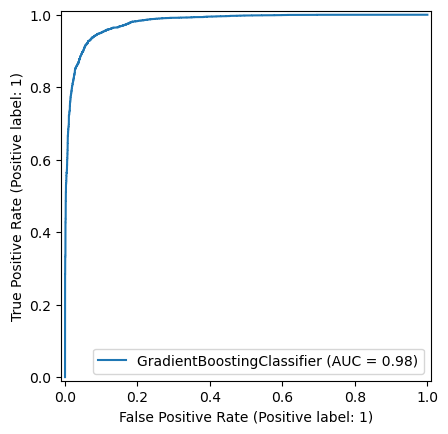

20:56:58.758 | INFO    | Task run 'roc_curve_analysis-caa' - Task 'roc_curve_analysis' completed in 0.13 seconds

20:56:58.763 | INFO    | Task run 'roc_curve_analysis-caa' - Finished in state Completed()

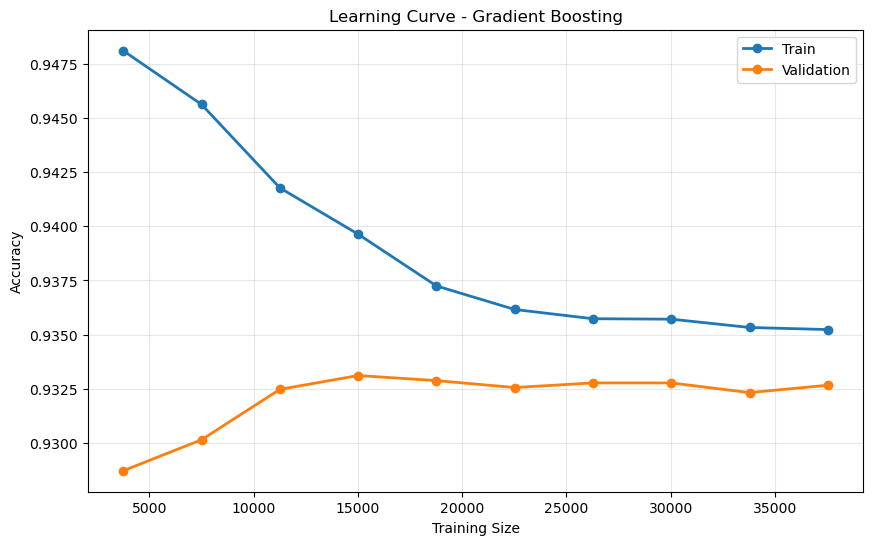

20:57:59.652 | INFO    | Task run 'plot_learning_curve-f1e' - Task 'plot_learning_curve' completed in 60.61 seconds

20:57:59.661 | INFO    | Task run 'plot_learning_curve-f1e' - Finished in state Completed()

Random Forest

Resultados de la validación cruzada en Random Forest: [0.9398977  0.93552169 0.93786635 0.93946499 0.94234253]
Resultado promedio de la validación cruzada en Random Forest: 0.9390
Exactitud (accuracy) en prueba (testing) del Random Forest: 0.9393810213999488


20:58:22.884 | INFO    | Task run 'random_forest-52f' - Task 'random_forest' completed in 22.84 seconds

20:58:22.889 | INFO    | Task run 'random_forest-52f' - Finished in state Completed()

Visualización de desempeño con Matriz de Confusión:
Confusion Matrix
[[5209  391]
 [ 320 5809]]


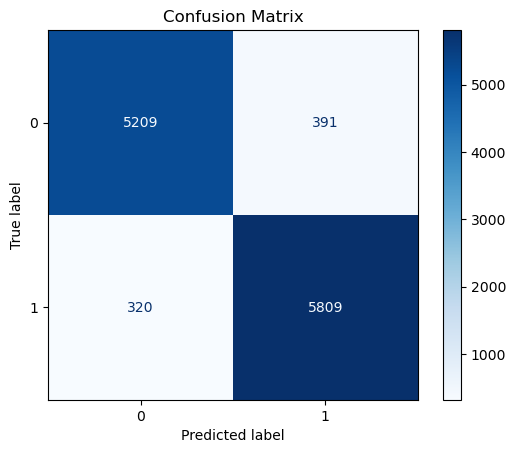

20:58:23.392 | INFO    | Task run 'confusion_matrix-4c8' - Task 'confusion_matrix' completed in 0.19 seconds

20:58:23.399 | INFO    | Task run 'confusion_matrix-4c8' - Finished in state Completed()

Clasification Report
              precision    recall  f1-score   support

           0       0.94      0.93      0.94      5600
           1       0.94      0.95      0.94      6129

    accuracy                           0.94     11729
   macro avg       0.94      0.94      0.94     11729
weighted avg       0.94      0.94      0.94     11729



20:58:23.701 | INFO    | Task run 'show_classificationreport-e8c' - Task 'show_classificationreport' completed in 0.14 seconds

20:58:23.707 | INFO    | Task run 'show_classificationreport-e8c' - Finished in state Completed()

AUC-ROC: 0.9850


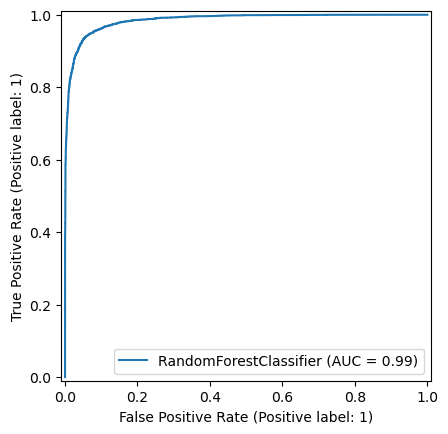

20:58:24.145 | INFO    | Task run 'roc_curve_analysis-7e7' - Task 'roc_curve_analysis' completed in 0.29 seconds

20:58:24.149 | INFO    | Task run 'roc_curve_analysis-7e7' - Finished in state Completed()

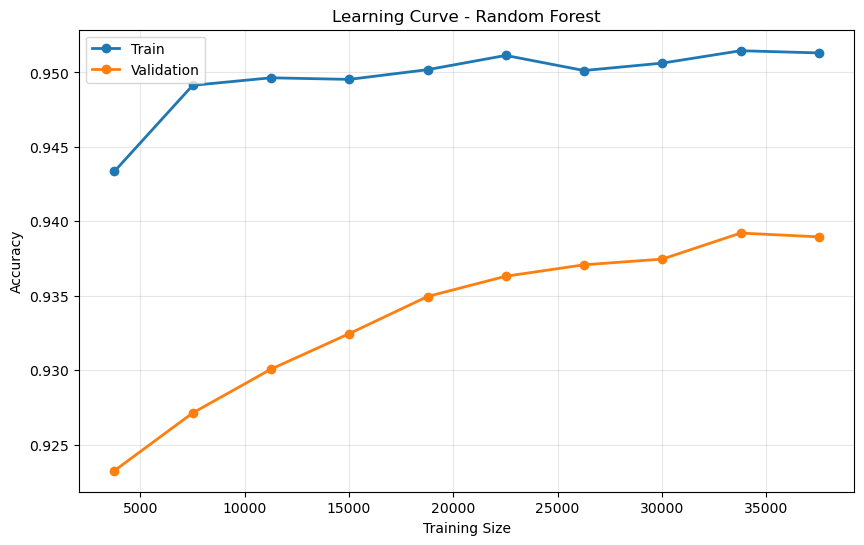

20:58:48.781 | INFO    | Task run 'plot_learning_curve-877' - Task 'plot_learning_curve' completed in 24.31 seconds

20:58:48.787 | INFO    | Task run 'plot_learning_curve-877' - Finished in state Completed()

Knn
Comparación de hiperparámetros:
KNN (n_neighbors=1) - Prueba de accuracy: 0.8671
KNN (n_neighbors=3) - Prueba de accuracy: 0.8548
KNN (n_neighbors=5) - Prueba de accuracy: 0.8489
KNN (n_neighbors=7) - Prueba de accuracy: 0.8426
Comparación de predicciones (primeras 5 filas):
       qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  \
8833             2               0                  2              2   
54083            2               0                  0              1   
54281            2               0                  0              1   
47386            4               0                  0              0   
37042            2               0                  0              0   

       qty_questionmark_url  qty_equal_url  qty_at_url  qty_and_url  \
8833                      0              0           0            0   
54083                     0              0           0            0   
54281                     0              0           0            0   
473

20:59:04.656 | INFO    | Task run 'knn-522' - Task 'knn' completed in 15.49 seconds

20:59:04.664 | INFO    | Task run 'knn-522' - Finished in state Completed()

Visualización de desempeño con Matriz de Confusión:
Confusion Matrix
[[4583 1017]
 [ 829 5300]]


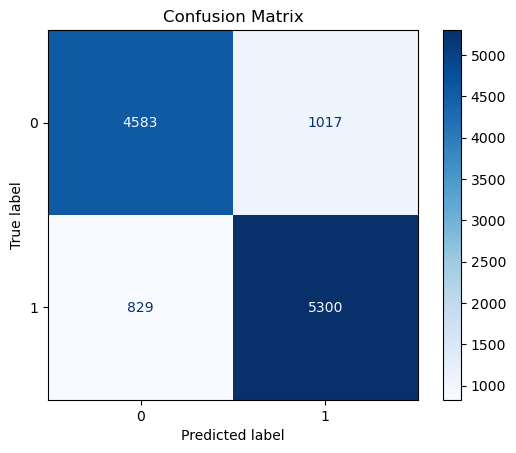

20:59:06.245 | INFO    | Task run 'confusion_matrix-1b5' - Task 'confusion_matrix' completed in 1.43 seconds

20:59:06.250 | INFO    | Task run 'confusion_matrix-1b5' - Finished in state Completed()

Clasification Report
              precision    recall  f1-score   support

           0       0.85      0.82      0.83      5600
           1       0.84      0.86      0.85      6129

    accuracy                           0.84     11729
   macro avg       0.84      0.84      0.84     11729
weighted avg       0.84      0.84      0.84     11729



20:59:07.677 | INFO    | Task run 'show_classificationreport-a6a' - Task 'show_classificationreport' completed in 1.28 seconds

20:59:07.691 | INFO    | Task run 'show_classificationreport-a6a' - Finished in state Completed()

AUC-ROC: 0.9142


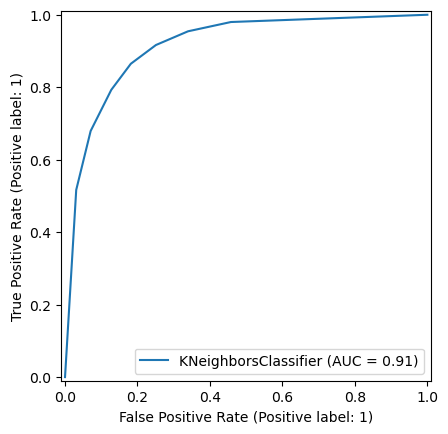

20:59:09.655 | INFO    | Task run 'roc_curve_analysis-798' - Task 'roc_curve_analysis' completed in 1.81 seconds

20:59:09.655 | INFO    | Task run 'roc_curve_analysis-798' - Finished in state Completed()

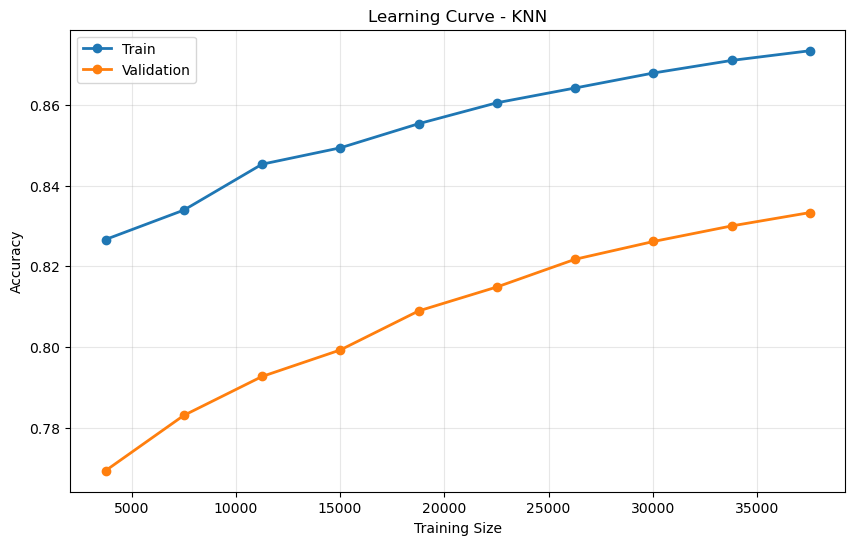

21:00:15.750 | INFO    | Task run 'plot_learning_curve-313' - Task 'plot_learning_curve' completed in 65.74 seconds

21:00:15.760 | INFO    | Task run 'plot_learning_curve-313' - Finished in state Completed()

Knn Scaler
KNN Scaler(n_neighbors=1) - Prueba de accuracy: 0.9303
KNN Scaler(n_neighbors=3) - Prueba de accuracy: 0.9299
KNN Scaler(n_neighbors=5) - Prueba de accuracy: 0.9309
KNN Scaler(n_neighbors=7) - Prueba de accuracy: 0.9291
Comparación de predicciones:
       qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  \
8833             2               0                  2              2   
54083            2               0                  0              1   
54281            2               0                  0              1   
47386            4               0                  0              0   
37042            2               0                  0              0   

       qty_questionmark_url  qty_equal_url  qty_at_url  qty_and_url  \
8833                      0              0           0            0   
54083                     0              0           0            0   
54281                     0              0           0            0   
47386                  

21:00:29.836 | INFO    | Task run 'knn_scaler-4a9' - Task 'knn_scaler' completed in 13.73 seconds

21:00:29.842 | INFO    | Task run 'knn_scaler-4a9' - Finished in state Completed()

Visualización de desempeño con Matriz de Confusión:
Confusion Matrix
[[5196  404]
 [ 406 5723]]


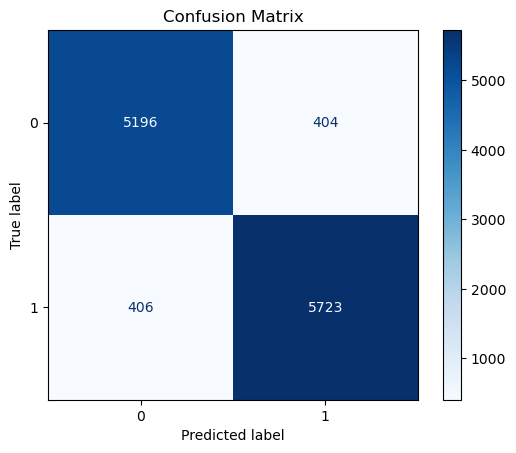

21:00:31.584 | INFO    | Task run 'confusion_matrix-91b' - Task 'confusion_matrix' completed in 1.62 seconds

21:00:31.592 | INFO    | Task run 'confusion_matrix-91b' - Finished in state Completed()

Clasification Report
              precision    recall  f1-score   support

           0       0.93      0.93      0.93      5600
           1       0.93      0.93      0.93      6129

    accuracy                           0.93     11729
   macro avg       0.93      0.93      0.93     11729
weighted avg       0.93      0.93      0.93     11729



21:00:33.223 | INFO    | Task run 'show_classificationreport-eb3' - Task 'show_classificationreport' completed in 1.52 seconds

21:00:33.228 | INFO    | Task run 'show_classificationreport-eb3' - Finished in state Completed()

AUC-ROC: 0.9733


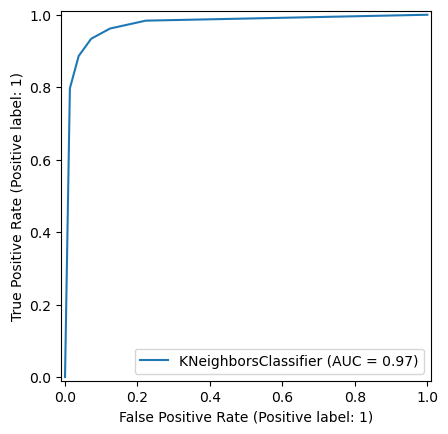

21:00:35.709 | INFO    | Task run 'roc_curve_analysis-8bb' - Task 'roc_curve_analysis' completed in 2.36 seconds

21:00:35.714 | INFO    | Task run 'roc_curve_analysis-8bb' - Finished in state Completed()

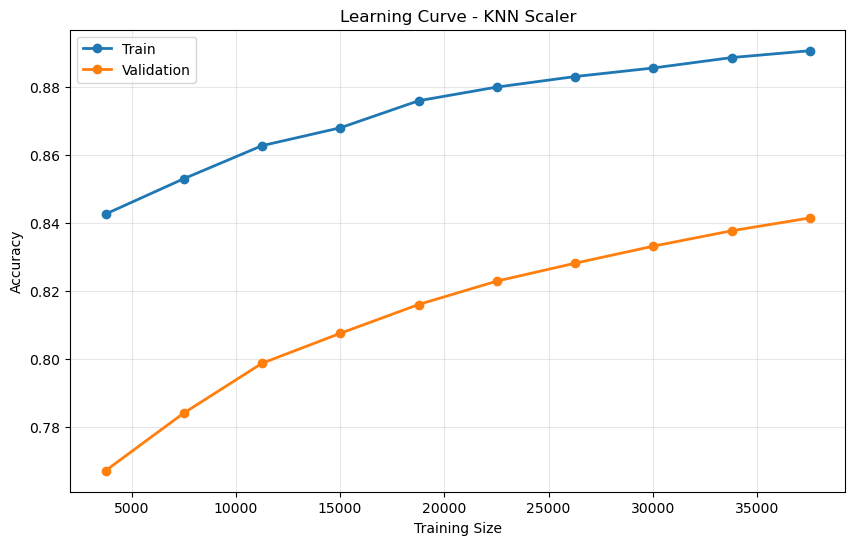

21:01:45.732 | INFO    | Task run 'plot_learning_curve-23f' - Task 'plot_learning_curve' completed in 69.67 seconds

21:01:45.732 | INFO    | Task run 'plot_learning_curve-23f' - Finished in state Completed()

SVM
Comparación de predicciones (primeras 5 filas):
       qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  \
8833             2               0                  2              2   
54083            2               0                  0              1   
54281            2               0                  0              1   
47386            4               0                  0              0   
37042            2               0                  0              0   

       qty_questionmark_url  qty_equal_url  qty_at_url  qty_and_url  \
8833                      0              0           0            0   
54083                     0              0           0            0   
54281                     0              0           0            0   
47386                     0              0           0            0   
37042                     0              0           0            0   

       qty_exclamation_url  qty_space_url  ...  qty_nameservers  \
8833                 

21:17:10.342 | INFO    | Task run 'svm-73b' - Task 'svm' completed in 924.26 seconds

21:17:10.348 | INFO    | Task run 'svm-73b' - Finished in state Completed()

Visualización de desempeño con Matriz de Confusión:
Confusion Matrix
[[3447 2153]
 [1129 5000]]


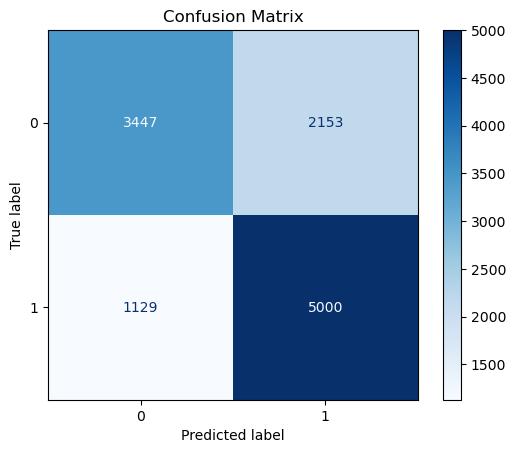

21:17:52.541 | INFO    | Task run 'confusion_matrix-d90' - Task 'confusion_matrix' completed in 42.04 seconds

21:17:52.548 | INFO    | Task run 'confusion_matrix-d90' - Finished in state Completed()

Clasification Report
              precision    recall  f1-score   support

           0       0.75      0.62      0.68      5600
           1       0.70      0.82      0.75      6129

    accuracy                           0.72     11729
   macro avg       0.73      0.72      0.72     11729
weighted avg       0.72      0.72      0.72     11729



21:18:35.684 | INFO    | Task run 'show_classificationreport-d62' - Task 'show_classificationreport' completed in 42.96 seconds

21:18:35.691 | INFO    | Task run 'show_classificationreport-d62' - Finished in state Completed()

AUC-ROC: 0.7696


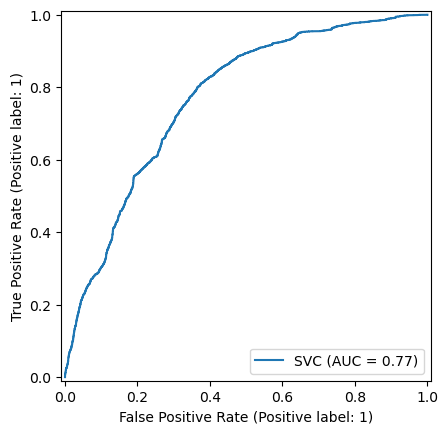

21:20:00.900 | INFO    | Task run 'roc_curve_analysis-e9b' - Task 'roc_curve_analysis' completed in 85.07 seconds

21:20:00.904 | INFO    | Task run 'roc_curve_analysis-e9b' - Finished in state Completed()

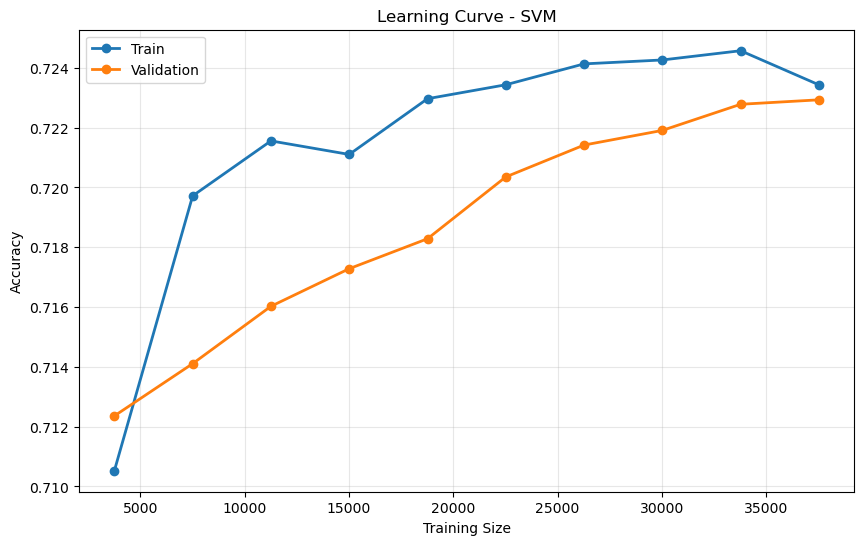

21:52:14.930 | INFO    | Task run 'plot_learning_curve-88e' - Task 'plot_learning_curve' completed in 1933.69 seconds

21:52:14.937 | INFO    | Task run 'plot_learning_curve-88e' - Finished in state Completed()

SVM Scaler
Comparación de predicciones (primeras 5 filas):
       qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  \
8833             2               0                  2              2   
54083            2               0                  0              1   
54281            2               0                  0              1   
47386            4               0                  0              0   
37042            2               0                  0              0   

       qty_questionmark_url  qty_equal_url  qty_at_url  qty_and_url  \
8833                      0              0           0            0   
54083                     0              0           0            0   
54281                     0              0           0            0   
47386                     0              0           0            0   
37042                     0              0           0            0   

       qty_exclamation_url  qty_space_url  ...  qty_nameservers  \
8833          

21:56:56.826 | INFO    | Task run 'svm_scaler-7c1' - Task 'svm_scaler' completed in 281.51 seconds

21:56:56.831 | INFO    | Task run 'svm_scaler-7c1' - Finished in state Completed()

Visualización de desempeño con Matriz de Confusión:
Confusion Matrix
[[5032  568]
 [ 415 5714]]


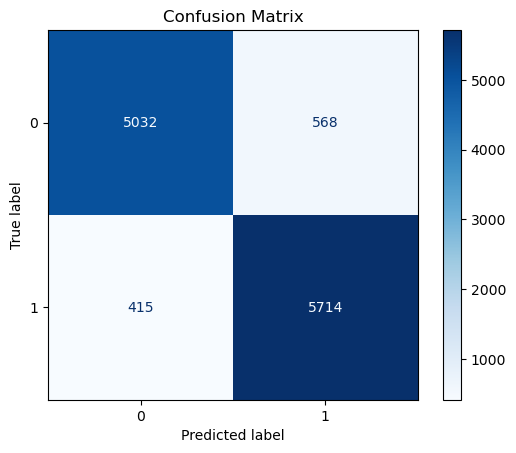

21:57:09.681 | INFO    | Task run 'confusion_matrix-b7a' - Task 'confusion_matrix' completed in 12.79 seconds

21:57:09.685 | INFO    | Task run 'confusion_matrix-b7a' - Finished in state Completed()

Clasification Report
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      5600
           1       0.91      0.93      0.92      6129

    accuracy                           0.92     11729
   macro avg       0.92      0.92      0.92     11729
weighted avg       0.92      0.92      0.92     11729



21:57:23.057 | INFO    | Task run 'show_classificationreport-a6b' - Task 'show_classificationreport' completed in 13.31 seconds

21:57:23.062 | INFO    | Task run 'show_classificationreport-a6b' - Finished in state Completed()

AUC-ROC: 0.9726


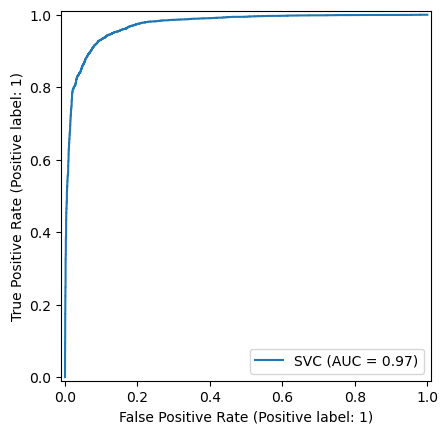

21:57:49.181 | INFO    | Task run 'roc_curve_analysis-084' - Task 'roc_curve_analysis' completed in 26.06 seconds

21:57:49.186 | INFO    | Task run 'roc_curve_analysis-084' - Finished in state Completed()

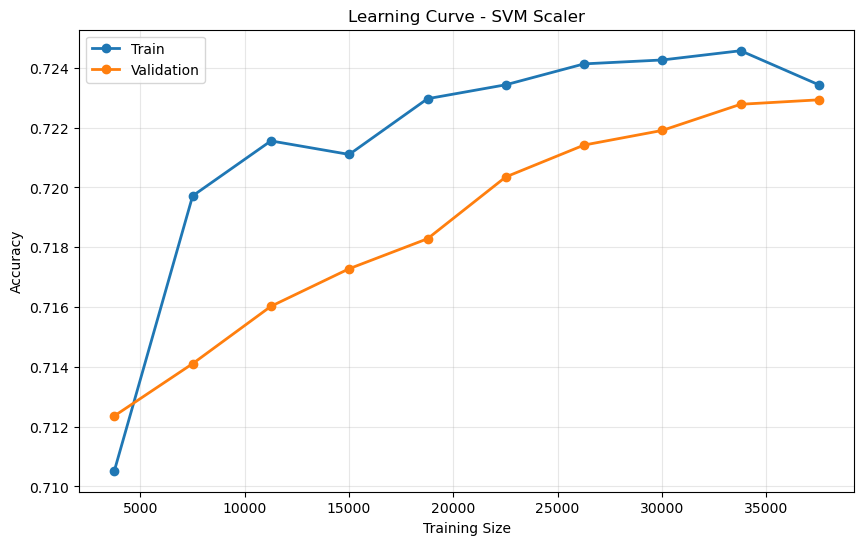

22:29:29.832 | INFO    | Task run 'plot_learning_curve-0e3' - Task 'plot_learning_curve' completed in 1900.35 seconds

22:29:29.840 | INFO    | Task run 'plot_learning_curve-0e3' - Finished in state Completed()

SVM con LinearSVC
Comparación de predicciones (primeras 5 filas):
       qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  \
8833             2               0                  2              2   
54083            2               0                  0              1   
54281            2               0                  0              1   
47386            4               0                  0              0   
37042            2               0                  0              0   

       qty_questionmark_url  qty_equal_url  qty_at_url  qty_and_url  \
8833                      0              0           0            0   
54083                     0              0           0            0   
54281                     0              0           0            0   
47386                     0              0           0            0   
37042                     0              0           0            0   

       qty_exclamation_url  qty_space_url  ...  qty_nameservers  \
8833   

22:29:35.813 | INFO    | Task run 'svm_linearsvc-892' - Task 'svm_linearsvc' completed in 5.56 seconds

22:29:35.818 | INFO    | Task run 'svm_linearsvc-892' - Finished in state Completed()

Visualización de desempeño con Matriz de Confusión:
Confusion Matrix
[[4713  887]
 [ 478 5651]]


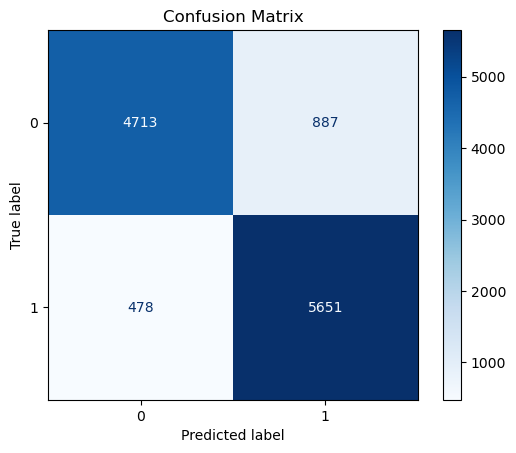

22:29:36.020 | INFO    | Task run 'confusion_matrix-c68' - Task 'confusion_matrix' completed in 0.11 seconds

22:29:36.025 | INFO    | Task run 'confusion_matrix-c68' - Finished in state Completed()

Clasification Report
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      5600
           1       0.86      0.92      0.89      6129

    accuracy                           0.88     11729
   macro avg       0.89      0.88      0.88     11729
weighted avg       0.89      0.88      0.88     11729



22:29:36.143 | INFO    | Task run 'show_classificationreport-b8b' - Task 'show_classificationreport' completed in 0.02 seconds

22:29:36.145 | INFO    | Task run 'show_classificationreport-b8b' - Finished in state Completed()

AUC-ROC: 0.9532


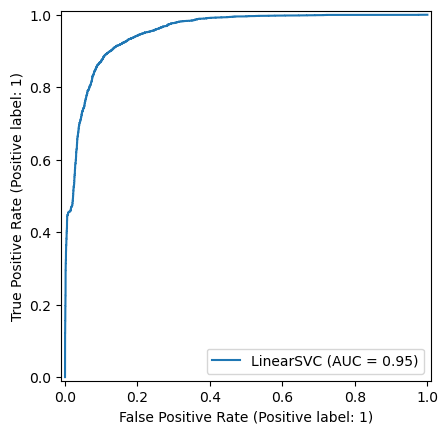

22:29:36.364 | INFO    | Task run 'roc_curve_analysis-652' - Task 'roc_curve_analysis' completed in 0.12 seconds

22:29:36.369 | INFO    | Task run 'roc_curve_analysis-652' - Finished in state Completed()

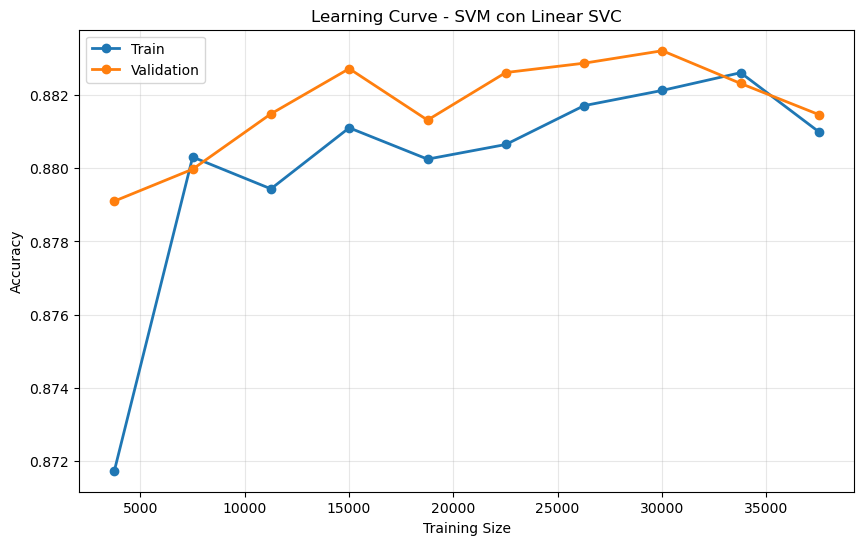

22:29:53.589 | INFO    | Task run 'plot_learning_curve-30d' - Task 'plot_learning_curve' completed in 16.94 seconds

22:29:53.593 | INFO    | Task run 'plot_learning_curve-30d' - Finished in state Completed()

SVM Scaler con LinearSVC
Comparación de predicciones (primeras 5 filas):
       qty_dot_url  qty_hyphen_url  qty_underline_url  qty_slash_url  \
8833             2               0                  2              2   
54083            2               0                  0              1   
54281            2               0                  0              1   
47386            4               0                  0              0   
37042            2               0                  0              0   

       qty_questionmark_url  qty_equal_url  qty_at_url  qty_and_url  \
8833                      0              0           0            0   
54083                     0              0           0            0   
54281                     0              0           0            0   
47386                     0              0           0            0   
37042                     0              0           0            0   

       qty_exclamation_url  qty_space_url  ...  qty_nameservers  \


22:30:06.541 | INFO    | Task run 'svm_scalerlinear-344' - Task 'svm_scalerlinear' completed in 12.58 seconds

22:30:06.547 | INFO    | Task run 'svm_scalerlinear-344' - Finished in state Completed()

Visualización de desempeño con Matriz de Confusión:
Confusion Matrix
[[4885  715]
 [ 467 5662]]


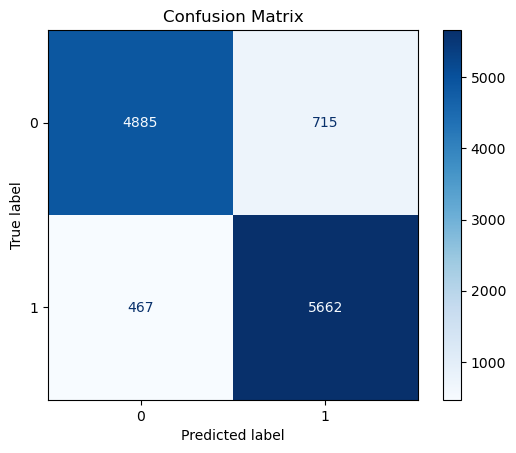

22:30:06.681 | INFO    | Task run 'confusion_matrix-2ba' - Task 'confusion_matrix' completed in 0.09 seconds

22:30:06.687 | INFO    | Task run 'confusion_matrix-2ba' - Finished in state Completed()

Clasification Report
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      5600
           1       0.89      0.92      0.91      6129

    accuracy                           0.90     11729
   macro avg       0.90      0.90      0.90     11729
weighted avg       0.90      0.90      0.90     11729



22:30:06.743 | INFO    | Task run 'show_classificationreport-e06' - Task 'show_classificationreport' completed in 0.01 seconds

22:30:06.748 | INFO    | Task run 'show_classificationreport-e06' - Finished in state Completed()

AUC-ROC: 0.9613


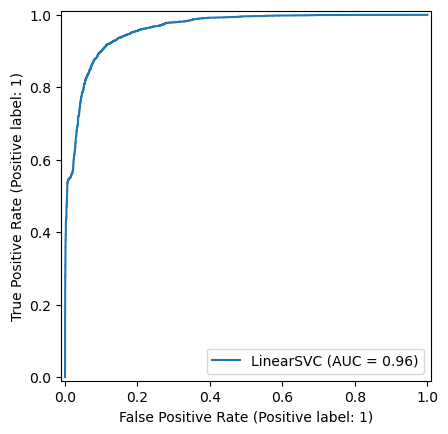

22:30:06.919 | INFO    | Task run 'roc_curve_analysis-073' - Task 'roc_curve_analysis' completed in 0.13 seconds

22:30:06.923 | INFO    | Task run 'roc_curve_analysis-073' - Finished in state Completed()

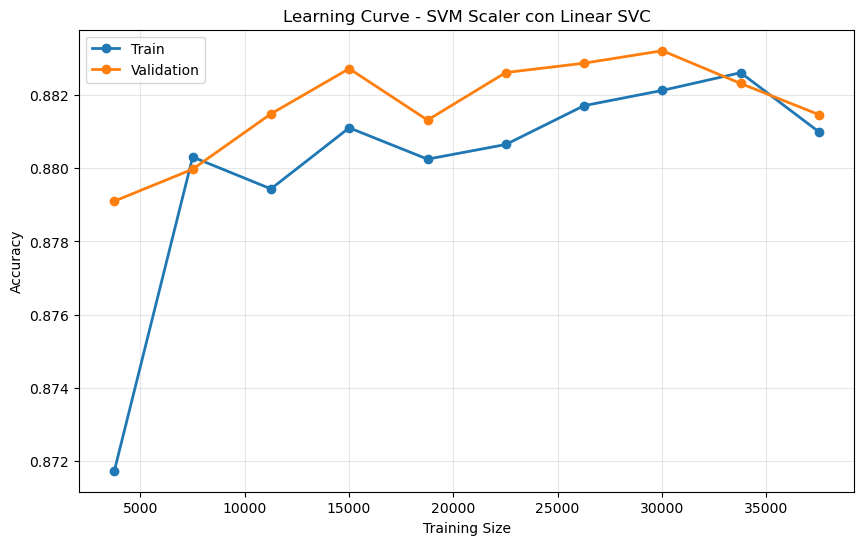

22:30:21.945 | INFO    | Task run 'plot_learning_curve-92e' - Task 'plot_learning_curve' completed in 14.74 seconds

22:30:21.953 | INFO    | Task run 'plot_learning_curve-92e' - Finished in state Completed()

c:\Users\Juan David\anaconda3\envs\bigdata_sql\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\Juan David\anaconda3\envs\bigdata_sql\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
c:\Users\Juan David\anaconda3\envs\bigdata_sql\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(


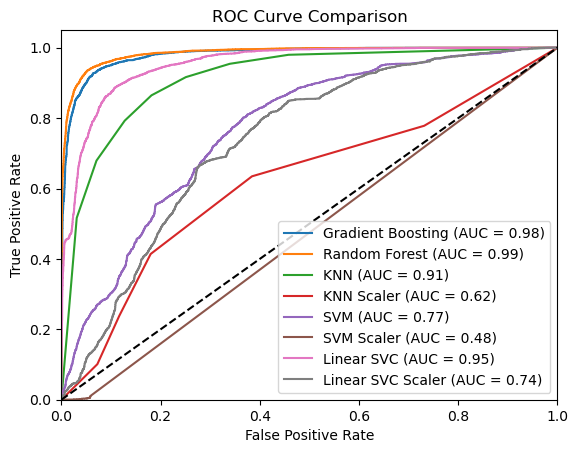

22:31:21.256 | INFO    | Task run 'multiple_roc-dff' - Task 'multiple_roc' completed in 58.82 seconds

22:31:21.277 | INFO    | Task run 'multiple_roc-dff' - Finished in state Completed()

c:\Users\Juan David\anaconda3\envs\bigdata_sql\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
c:\Users\Juan David\anaconda3\envs\bigdata_sql\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
c:\Users\Juan David\anaconda3\envs\bigdata_sql\Lib\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but LinearSVC was fitted without feature names
  warnings.warn(


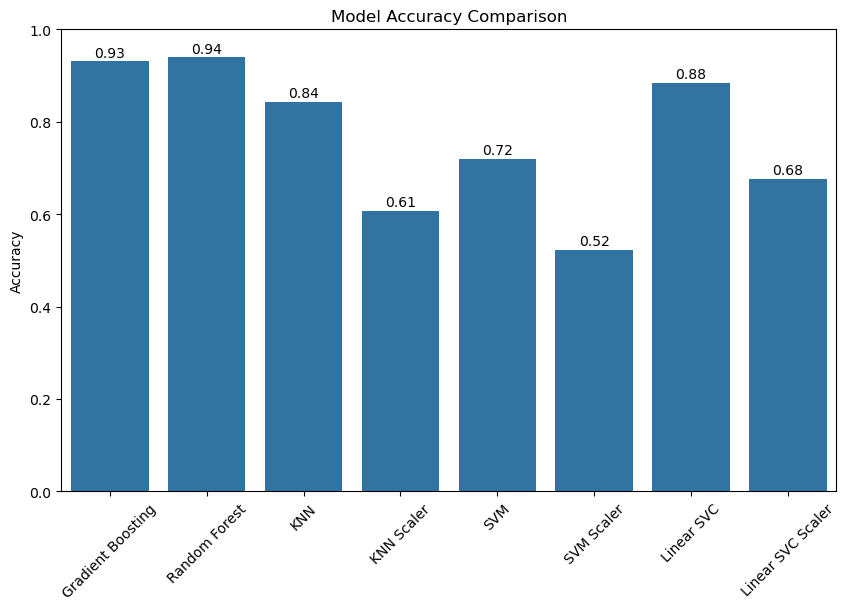

22:32:20.176 | INFO    | Task run 'bar_chart-6dc' - Task 'bar_chart' completed in 58.48 seconds

22:32:20.180 | INFO    | Task run 'bar_chart-6dc' - Finished in state Completed()

22:32:20.264 | INFO    | Flow run 'wild-goose' - Finished in state Completed()

In [22]:
@flow
def small_dataset_flow():
    df = load_data()
    distribution_plotter(df)
    descriptor(df)
    correlation(df)
    X_train, X_test, y_train, y_test = preprocessing(df)

    class_names = [0,1]

    gb_model = gradient_boosting(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, gb_model, X_test, y_test)
    show_classificationreport(gb_model, X_test, y_test, class_names)
    roc_curve_analysis(gb_model, X_test, y_test)
    plot_learning_curve(gb_model, X_train, y_train, "Gradient Boosting")

    rf_model =random_forest(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, rf_model, X_test, y_test)
    show_classificationreport(rf_model, X_test, y_test, class_names)
    roc_curve_analysis(rf_model, X_test, y_test)
    plot_learning_curve(rf_model, X_train, y_train, "Random Forest")

    knn_model = knn(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, knn_model, X_test, y_test)
    show_classificationreport(knn_model, X_test, y_test, class_names)
    roc_curve_analysis(knn_model, X_test, y_test)
    plot_learning_curve(knn_model, X_train, y_train, "KNN")

    knn_scaled, x_testscal_knn = knn_scaler(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, knn_scaled, x_testscal_knn, y_test)
    show_classificationreport(knn_scaled, x_testscal_knn, y_test, class_names)
    roc_curve_analysis(knn_scaled, x_testscal_knn, y_test)
    plot_learning_curve(knn_scaled, X_train, y_train, "KNN Scaler")

    svm_class_model = svm(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, svm_class_model, X_test, y_test)
    show_classificationreport(svm_class_model, X_test, y_test, class_names)
    roc_curve_analysis(svm_class_model, X_test, y_test)
    plot_learning_curve(svm_class_model, X_train, y_train, "SVM")

    svm_class_scaled, x_testscal_svm = svm_scaler(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, svm_class_scaled, x_testscal_svm, y_test)
    show_classificationreport(svm_class_scaled, x_testscal_svm, y_test, class_names)
    roc_curve_analysis(svm_class_scaled, x_testscal_svm, y_test)
    plot_learning_curve(svm_class_scaled, X_train, y_train, "SVM Scaler")

    linear_svmmodel = svm_linearsvc(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, linear_svmmodel, X_test, y_test)
    show_classificationreport(linear_svmmodel, X_test, y_test, class_names)
    roc_curve_analysis(linear_svmmodel, X_test, y_test)
    plot_learning_curve(linear_svmmodel, X_train, y_train, "SVM con Linear SVC")

    linear_svm_scaled, X_test_scaled_linear = svm_scalerlinear(X_train, X_test, y_train, y_test)
    confusion_matrix(class_names, linear_svm_scaled, X_test_scaled_linear, y_test)
    show_classificationreport(linear_svm_scaled, X_test_scaled_linear, y_test, class_names)
    roc_curve_analysis(linear_svm_scaled, X_test_scaled_linear, y_test)
    plot_learning_curve(linear_svm_scaled, X_train, y_train, "SVM Scaler con Linear SVC")

    models_dict = {
        "Gradient Boosting": gb_model,
        "Random Forest": rf_model,
        "KNN": knn_model,
        "KNN Scaler": knn_scaled,
        "SVM": svm_class_model,
        "SVM Scaler": svm_class_scaled,
        "Linear SVC": linear_svmmodel,
        "Linear SVC Scaler": linear_svm_scaled,
    }

    multiple_roc(models_dict, X_test, y_test)
    bar_chart(models_dict, X_test, y_test)
small_dataset_flow()